# Stock Sentiment Analysis
Natural Language Processing project that uses financial news headlines from finviz (https://finviz.com) to visualize and compare stock prospects for selected tickers over time   

The Sentiment Analysis Model is trained under 5 different approaches below, and the one with the best accuracy is selected as the final model.
- MLP (Multi Layer Perceptron)
- CNN (Convolutional Neural Netwrok)
- RNN
- LSTM
- GRU


In [1]:
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import json


## Training Data Set
Sentiment Analysis data for Financial News (https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news)   
This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

In [2]:
# reading csv file (debugging encoding)
colnames=['label', 'headline'] 
df = pd.read_csv('./data/all-data.csv',delimiter=',',encoding='latin-1', names=colnames, header=None)
df.head()

,label,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df.shape

(4846, 2)

In [4]:
cnt_pro = df['label'].value_counts()
print(cnt_pro)
print(type(cnt_pro.index))
print(type(cnt_pro.values))

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64
<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>


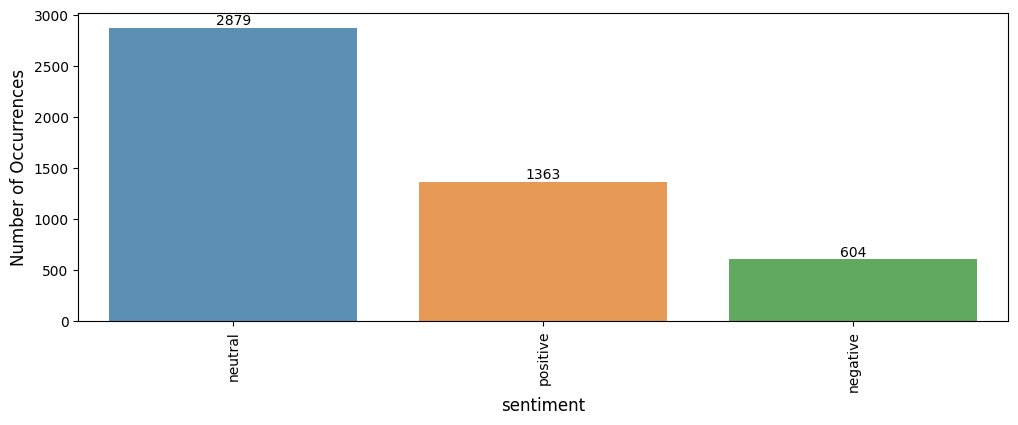

In [5]:
# visualizing data
cnt_pro = df['label'].value_counts()
plt.figure(figsize=(12,4))
# Create the bar plot and store the ax object
ax = sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)

# Add value labels on top of the bars
for p in ax.patches:
    height = int(p.get_height())  # Convert the height to an integer
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Data Processsing
- converting label to numeric (postive: 1, neutral: 0, negative: -1)
- cleaning text: tokenizing, removing punctuation, digits, convert to lowercase
- converting dataframe to numpy arrays
- fixing input data to tensors with same dimensions

In [6]:
#Convert label to numeric
sentiment  = {'positive': 1,'neutral': 0,'negative':-1} 

df.label = [sentiment[item] for item in df.label] 
print(df)

      label                                           headline
0         0  According to Gran , the company has no plans t...
1         0  Technopolis plans to develop in stages an area...
2        -1  The international electronic industry company ...
3         1  With the new production plant the company woul...
4         1  According to the company 's updated strategy f...
...     ...                                                ...
4841     -1  LONDON MarketWatch -- Share prices ended lower...
4842      0  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843     -1  Operating profit fell to EUR 35.4 mn from EUR ...
4844     -1  Net sales of the Paper segment decreased to EU...
4845     -1  Sales in Finland decreased by 10.5 % in Januar...

[4846 rows x 2 columns]


In [7]:
# convert headline to list of strings
# removing punctuation
punctstr = string.punctuation
punctstr = punctstr.replace('.','') # don't want to remove periods because they might represent decimal points
print(punctstr)

!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~


In [8]:
# cleaning text: puncuation, convert to lowercase
punctdigstr = string.punctuation
punctdigstr += "0123456789"

def cleanText(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', punctdigstr))
    text = text.replace(' s ', ' ') # removing 's

    text = text.split()
    return text

df['headline'] = df['headline'].apply(cleanText)

In [9]:
print(df[:20].headline)

max_length = df['headline'].apply(len).max()
print("Length of the longest list:", max_length)

0     [according, to, gran, the, company, has, no, p...
1     [technopolis, plans, to, develop, in, stages, ...
2     [the, international, electronic, industry, com...
3     [with, the, new, production, plant, the, compa...
4     [according, to, the, company, updated, strateg...
5     [financing, of, aspocomp, growth, aspocomp, is...
6     [for, the, last, quarter, of, componenta, net,...
7     [in, the, third, quarter, of, net, sales, incr...
8     [operating, profit, rose, to, eur, mn, from, e...
9     [operating, profit, totalled, eur, mn, up, fro...
10    [teliasonera, tlsn, said, the, offer, is, in, ...
11    [stora, enso, norske, skog, mreal, upmkymmene,...
12    [a, purchase, agreement, for, tons, of, gasoli...
13    [finnish, talentum, reports, its, operating, p...
14    [clothing, retail, chain, seppælæ, sales, incr...
15    [consolidated, net, sales, increased, to, reac...
16    [foundries, division, reports, its, sales, inc...
17    [helsinki, afx, shares, closed, higher, le

In [10]:
# this is for determining the input_dim of the embedding layers later on
# Concatenate all lists in the 'headline' column to create a single list containing all words
all_words = [word for sublist in df['headline'] for word in sublist]

# Calculate the vocabulary size, which is the total number of unique words
vocabulary_size = len(set(all_words))

print("Vocabulary size:", vocabulary_size)

Vocabulary size: 9494


In [11]:
# Initialize the tokenizer
max_words = vocabulary_size  # Set the maximum number of words in your vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # <OOV> for out-of-vocabulary words

# Fit the tokenizer on text data
tokenizer.fit_on_texts(df['headline'])

# Get the word-to-index mapping
word_index = tokenizer.word_index

# Convert each headline into a sequence of word indices
sequences = tokenizer.texts_to_sequences(df['headline'])

In [12]:
with open('word_index_library.json', 'w') as f:
    json.dump(word_index, f)

In [13]:
print(sequences)
print(type(sequences))

[[75, 6, 3252, 2, 12, 17, 203, 278, 6, 577, 106, 69, 6, 122, 2580, 28, 10, 357, 2, 12, 10, 666], [750, 278, 6, 789, 4, 1661, 33, 161, 3, 203, 1071, 86, 550, 1662, 4, 104, 6, 3253, 77, 709, 4, 1155, 500, 5, 667, 2, 834, 21], [2, 241, 578, 121, 12, 279, 17, 1156, 323, 3254, 3, 138, 13, 15, 1072, 234, 4642, 6, 125, 501, 2, 12, 2160, 2, 4643, 3, 15, 220, 876, 2, 790, 4644, 204], [18, 2, 40, 69, 81, 2, 12, 110, 93, 15, 221, 6, 1355, 2, 132, 93, 4, 433, 5, 110, 579, 2, 183, 3, 611, 455, 5, 1492, 93, 2, 69, 1073], [75, 6, 2, 12, 2161, 291, 9, 2, 222, 251, 988, 7, 456, 29, 26, 167, 4, 2, 315, 3, 18, 33, 36, 30, 434, 3, 3, 29, 26], [791, 3, 478, 167, 478, 10, 4645, 4646, 15, 167, 291, 19, 2162, 1356, 14, 3255, 94, 1663, 4647, 1357, 1074, 1664, 2581], [9, 2, 126, 44, 3, 580, 29, 26, 1890, 6, 102, 13, 102, 9, 2, 135, 42, 7, 39, 125, 151, 25, 2163, 6, 7, 4648, 270, 30, 13, 7, 270, 58, 3, 102], [4, 2, 148, 44, 3, 29, 26, 87, 19, 6, 8, 16, 5, 36, 30, 19, 6, 8, 16], [36, 30, 96, 6, 8, 16, 13, 8, 16, 

In [14]:
# Create a new DataFrame with the 'headline' column containing the sequences
df_headline_tokenized = pd.DataFrame({'headline': sequences})

print(df_headline_tokenized)

                                               headline
0     [75, 6, 3252, 2, 12, 17, 203, 278, 6, 577, 106...
1     [750, 278, 6, 789, 4, 1661, 33, 161, 3, 203, 1...
2     [2, 241, 578, 121, 12, 279, 17, 1156, 323, 325...
3     [18, 2, 40, 69, 81, 2, 12, 110, 93, 15, 221, 6...
4     [75, 6, 2, 12, 2161, 291, 9, 2, 222, 251, 988,...
...                                                 ...
4841  [658, 2707, 45, 316, 1296, 289, 4, 658, 699, 2...
4842  [3285, 522, 26, 199, 19, 71, 379, 6, 27, 1377,...
4843  [36, 30, 199, 6, 8, 16, 13, 8, 16, 4, 156, 124...
4844  [29, 26, 3, 2, 128, 648, 133, 6, 8, 16, 4, 2, ...
4845  [26, 4, 32, 133, 19, 4, 198, 151, 26, 815, 32,...

[4846 rows x 1 columns]


In [15]:
#split into training and testing data (80% - 20%)
X = df_headline_tokenized  # Features
y = df['label']              # Target

# Set the proportion for training and testing (e.g., 80% for training, 20% for testing)
test_size = 0.2

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


In [16]:
print(X_train)
print(y_train)

                                               headline
432   [4, 122, 696, 274, 281, 734, 50, 4870, 106, 2,...
3071  [487, 484, 1145, 6, 7884, 1246, 6, 183, 115, 4...
289   [2, 12, 227, 15, 29, 26, 4, 2, 52, 192, 3, 6, ...
2588  [2, 649, 11, 22, 1785, 534, 5, 10, 631, 185, 7...
4121  [64, 5, 8745, 152, 28, 8746, 8747, 8748, 11, 2...
...                                                 ...
4426  [2, 1292, 692, 136, 7, 100, 99, 37, 55, 37, 74...
466   [3389, 3390, 91, 326, 3391, 2, 1208, 3392, 3, ...
3092  [70, 226, 636, 225, 423, 256, 20, 67, 570, 5, ...
3772            [2, 649, 10, 117, 3, 2, 8494, 114, 131]
860   [445, 162, 848, 23, 1043, 5, 201, 12, 453, 43,...

[3876 rows x 1 columns]
432     0
3071    0
289     1
2588    0
4121    0
       ..
4426   -1
466     1
3092    0
3772    0
860     1
Name: label, Length: 3876, dtype: int64


In [17]:
# convert the training and testing data into numpy arrays
X_train= X_train['headline'].values
X_test = X_test['headline'].values

print(X_train)
print(type(X_train))


[list([4, 122, 696, 274, 281, 734, 50, 4870, 106, 2, 697, 6, 4871])
 list([487, 484, 1145, 6, 7884, 1246, 6, 183, 115, 469, 9, 2103, 946, 3, 395, 156, 7885, 62])
 list([2, 12, 227, 15, 29, 26, 4, 2, 52, 192, 3, 6, 925, 2, 438, 39, 441])
 ...
 list([70, 226, 636, 225, 423, 256, 20, 67, 570, 5, 95, 1186, 3879, 2982, 2451, 2341, 2085, 20, 92, 20, 164, 83, 70, 256, 20, 485, 149, 2450, 5, 82, 237, 648, 70])
 list([2, 649, 10, 117, 3, 2, 8494, 114, 131])
 list([445, 162, 848, 23, 1043, 5, 201, 12, 453, 43, 112, 5259, 21, 61, 25, 31, 331, 7, 8, 27, 119, 35, 1384, 6, 95, 531, 1224, 201, 63, 18, 5260])]
<class 'numpy.ndarray'>


In [18]:
# convert the training and testing data into numpy arrays
# y is a pandas series so require different conversion
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(y_train)
print(type(y_train))

[0 0 1 ... 0 0 1]
<class 'numpy.ndarray'>


In [19]:
# Convert y_train, y_test into one-hot encoded format
num_classes = 3
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [20]:
print(y_train)
print(type(y_train))

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
<class 'numpy.ndarray'>


In [21]:
# convert headline list to tensor and convert with same length (50)
max_words = 50
X_train = sequence.pad_sequences(X_train, maxlen = max_words, dtype=object)
X_test = sequence.pad_sequences(X_test, maxlen=max_words, dtype=object)

In [22]:
print("X_train.shape: ",  X_train.shape)
print("X_test.shape: " , X_test.shape)

X_train.shape:  (3876, 50)
X_test.shape:  (970, 50)


In [23]:
print(X_train[0])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 4 122 696 274 281 734 50 4870 106 2 697 6 4871]


In [24]:
# debugging: need to convert all values to same type
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [25]:
print(X_train[0])

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 4.000e+00 1.220e+02 6.960e+02 2.740e+02 2.810e+02
 7.340e+02 5.000e+01 4.870e+03 1.060e+02 2.000e+00 6.970e+02 6.000e+00
 4.871e+03]


In [26]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  (3876, 50)
y_train.shape:  (3876, 3)


## Text Data Vectorization
Purpose:
- map text to geometrical space, using space to describe relationship between text 
- RNN, LSTM, and GRU 's input and output data are all vectors

Implementation: Adding Embedding layer with Keras

In [27]:
# Embedding must be the first layer of sequential model
model = Sequential()
# setting output dimension to 100 initially
model.add(Embedding(vocabulary_size, 100, input_length=max_words))

## Using MLP for Sentiment Analysis
observed how people built their MLP archtitecture in similar sentiment analysis projects

In [28]:
num_classes = 3  # Three classes: positive, neutral, and negative
MLP_model = model
MLP_model.add(Dropout(0.25)) # 25% of the units will be set to 0 during training
MLP_model.add(Flatten())    # flatten to 1D vector
MLP_model.add(Dense(256, activation="relu")) # relu: non-linearity
MLP_model.add(Dropout(0.25))
MLP_model.add(Dense(units=num_classes, activation='softmax'))  # Output layer

In [29]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           949400    
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 256)               1280256   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2230427 (8.51 MB)
Trainable params: 223042

In [30]:
# compiling model
# For multi-class classification with integer labels, 'sparse_categorical_crossentropy' is used.
MLP_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
MLP_history = MLP_model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=102, verbose=2)

Epoch 1/5
31/31 - 0s - loss: 0.9173 - accuracy: 0.5865 - val_loss: 0.8712 - val_accuracy: 0.6198 - 491ms/epoch - 16ms/step
Epoch 2/5
31/31 - 0s - loss: 0.7441 - accuracy: 0.6671 - val_loss: 0.8005 - val_accuracy: 0.6637 - 237ms/epoch - 8ms/step
Epoch 3/5
31/31 - 0s - loss: 0.4719 - accuracy: 0.8013 - val_loss: 0.7700 - val_accuracy: 0.6662 - 248ms/epoch - 8ms/step
Epoch 4/5
31/31 - 0s - loss: 0.2277 - accuracy: 0.9271 - val_loss: 0.8056 - val_accuracy: 0.6778 - 296ms/epoch - 10ms/step
Epoch 5/5
31/31 - 0s - loss: 0.1068 - accuracy: 0.9761 - val_loss: 0.8249 - val_accuracy: 0.6804 - 267ms/epoch - 9ms/step
